In [1]:
# import os
# import sys
# module_path = os.path.abspath(os.path.join('../../'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
# # module_path = os.path.abspath(os.path.join('../../src/twoDimensionalSPH'))
# # if module_path not in sys.path:
# #     sys.path.append(module_path)
    

In [2]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
import yaml
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning

warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)

In [3]:
import diffSPH

In [4]:
from diffSPH.deltaSPH import deltaSPHSimulation
from diffSPH.dfsph import dfsphSimulation

def loadConfig(config):
    with open(config, 'r') as file:
        tomlConfig = file.read()
    parsedConfig = tomli.loads(tomlConfig)
    simulationScheme = 'deltaSPH'
    if 'simulation' in parsedConfig:
        if 'scheme' in parsedConfig['simulation']:
            simulationScheme = parsedConfig['simulation']['scheme']
            
    if simulationScheme == 'deltaSPH' or simulationScheme == 'deltaPlus':
        return parsedConfig, deltaSPHSimulation
    if simulationScheme == 'dfsph':
        return parsedConfig, dfsphSimulation
    

Cuda compiler: /home/winchenbach/anaconda3/envs/torch2


In [5]:
import seaborn as sns
from diffSPH.util import evalArea
from diffSPH.noise.generator import generatePerlin, generateSimplex, generateOctaveNoise
from scipy import interpolate
from diffSPH.modules.neighborSearch import radiusCompactHashMap, periodicNeighborSearch
from diffSPH.util import scatter_sum
from diffSPH.kernels import *
from diffSPH.randomParticles import generatePeriodicRandomParticles

In [6]:
# def generatePeriodicRandomParticles(
#     nx, minDomain = [-1,-1], maxDomain = [1,1], targetNeighbors = 20,
#     noiseN = 256, noiseResolution = 2, noiseOctaves = 4,
#     noiseLacunarity = 2, noisePersistance = 0.25, noiseSeed = 1337
# ):
#     dx = (maxDomain[0] - minDomain[0]) / nx            
#     area = dx**2
#     area =  minimize(lambda r: evalArea(r[0], dx, torch.float32, 'cpu', targetNeighbors = targetNeighbors), area, method="nelder-mead", bounds =[(area * 1e-5,area *2)], tol = 1e-7).x[0]
#     support = np.single(np.sqrt(area / np.pi * targetNeighbors))
    
    
#     xx = np.linspace(minDomain[0] + dx / 2, maxDomain[0] - dx / 2, nx)
#     yy = np.linspace(minDomain[1] + dx / 2, maxDomain[1] - dx / 2, nx)

#     XX, YY = np.meshgrid(xx,yy)
#     ptcls = np.stack((XX,YY), axis = 2).flatten().reshape((nx * nx, 2))
    
#     xx, yy, noise = generateOctaveNoise(n = noiseN, baseFrequency = noiseResolution, \
#                     octaves = noiseOctaves, lacunarity = noiseLacunarity, persistence = noisePersistance, \
#                         seed = noiseSeed, kind = 'simplex')

# # filtered = filterNoise(noise, minDomain, minCenter, boundary = self.config['generative']['boundaryWidth'], nd = np.array(self.config['generative']['nd']), n = self.config['generative']['n'], dh = 1e-2)
#     noise = noise.numpy()
#     noiseSampler = interpolate.RegularGridInterpolator((np.linspace(minDomain[0],maxDomain[0],noiseN), np.linspace(minDomain[1],maxDomain[1],noiseN)), noise, bounds_error = False, fill_value = None, method = 'linear')


#     x = torch.tensor(ptcls).type(torch.float32)
#     i, j, fluidDistances, fluidRadialDistances = periodicNeighborSearch(torch.tensor(ptcls).type(torch.float32), minDomain, maxDomain, support, True, True, True)

#     rho = scatter_sum(area * kernel(fluidRadialDistances, support), i, dim = 0, dim_size = x.shape[0])

#     potential = torch.tensor(noiseSampler((x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy()))).to(x.device).type(x.dtype)

#     gradTerm = (area / rho[j]  *  (potential[j] - potential[i]))[:,None] * kernelGradient(fluidRadialDistances, fluidDistances, support)

#     potentialGradient = scatter(gradTerm, i, dim=0, dim_size=x.size(0), reduce="add")

#     velocities = torch.zeros_like(potentialGradient)
#     velocities[:,0] = potentialGradient[:,1]
#     velocities[:,1] = -potentialGradient[:,0]

#     gterm = area / rho[j]  * torch.einsum('nd, nd -> n', velocities[j] - velocities[i], kernelGradient(fluidRadialDistances, fluidDistances, support))

#     div = scatter(gterm, i, dim=0, dim_size=x.size(0), reduce="add")
    
#     return x, dx, area, support, potential, rho, velocities, div

In [7]:

from diffSPH.modules.neighborSearch import periodicNeighborSearchXY
from diffSPH.kernels import kernel

# positions, dx, area, support, potential, rho, velocities, div = generatePeriodicRandomParticles(128, noiseOctaves = 3, targetNeighbors = 27, noiseSeed = 1234, noiseResolution = 1, noisePersistance=0.5)


# nx = 128
# x = np.linspace(-1,1,nx)
# y = np.linspace(-1,1,nx)
# xx, yy = np.meshgrid(x,y)
# pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = 'cpu', dtype = positions.dtype)
# print(pos.shape)
# i, j, distances, radialDistances = periodicNeighborSearchXY(pos, positions, 
#                                                             np.array([-1,-1]), np.array([1,1]), 
#                                                             support, 
#                                                             True, True)


# vel = scatter(velocities[i] * (area / rho[i] * kernel(radialDistances, support))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')

# vel = velocities

# fig, axis = plt.subplots(1, 6, figsize=(20,4), sharex = False, sharey = False, squeeze = False)
# xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
# yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)

# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
# # fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)


# def pMesh(fig, axis, xx,yy,data,title):
#     sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
#     axis.axis('equal')

#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
#     cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
#     cbar.ax.tick_params(labelsize=8) 
#     axis.set_title(title)
#     return sc

# def pMesh2(fig, axis, xx,yy,data,title):
#     sc = axis.pcolormesh(xx,yy,data, cmap = 'RdBu', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
#     # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
#     axis.axis('equal')

#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
#     cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
#     cbar.ax.tick_params(labelsize=8) 
#     axis.set_title(title)
#     return sc
# def pMesh3(fig, axis, xx,yy,data,title):
#     sc = axis.pcolormesh(xx,yy,data, cmap = 'jet', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
#     # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
#     axis.axis('equal')

#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
#     cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
#     cbar.ax.tick_params(labelsize=8) 
#     axis.set_title(title)
#     return sc

# xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
# yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
# vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]
# divergence = np.gradient(xVel)[0] - np.gradient(xVel)[1]

# pMeshV = pMesh3(fig,axis[0,1], xx, yy, divergence, 'divergence')
# pMeshV = pMesh2(fig,axis[0,2], xx, yy, vorticity, 'vorticity')
# pMeshX = pMesh2(fig,axis[0,3], xx, yy, xVel, 'x velocity')
# pMeshY = pMesh2(fig,axis[0,4], xx, yy, yVel, 'y velocity')
# pMeshN = pMesh( fig,axis[0,5], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# # axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# # axis[0,0].set_xlim(-1,1)
# # axis[0,0].set_ylim(-1,1)
# # axis[0,0].set_aspect(1)
# # axis[0,0].axis('equal')
# # fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles']))

# fig.tight_layout()

In [8]:
config = 'configs/periodicDomain.toml'

with open(config, 'r') as file:
    tomlConfig = file.read()
parsedConfig = tomli.loads(tomlConfig)

simulationModel = deltaSPHSimulation
# simulationModel = dfsphSimulation

sphSimulation = simulationModel(parsedConfig)
sphSimulation.initializeSimulation()
state = sphSimulation.simulationState
state['fluidVelocity'] = 4.0 * state['fluidVelocity'] / torch.max(torch.linalg.norm(state['fluidVelocity'], dim = -1))

# A = 1
# B = -1
# k = np.pi
# state['fluidVelocity'][:,0] =  4 * torch.cos(k * state['fluidPosition'][:,0]) * torch.sin(k * state['fluidPosition'][:,1])
# state['fluidVelocity'][:,1] = -4 * torch.sin(k * state['fluidPosition'][:,0]) * torch.cos(k * state['fluidPosition'][:,1])


sphSimulation.integrate()


/home/winchenbach/dev/diffSPH/src/diffSPH/simulationBase.py:350: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emitterPositions = torch.tensor(self.generated['ptcls'], dtype = self.dtype, device = self.device)


In [9]:
from diffSPH.modules.neighborSearch import periodicNeighborSearchXY
from diffSPH.kernels import kernel


nx = 128
x = np.linspace(-1,1,nx)
y = np.linspace(-1,1,nx)
# x = np.linspace(0,2*np.pi,nx)
# y = np.linspace(0,2*np.pi,nx)
xx, yy = np.meshgrid(x,y)
pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
print(pos.shape)
i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                            sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                            sphSimulation.config['particle']['support'], 
                                                            sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])


vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')


torch.Size([16384, 2])


/home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


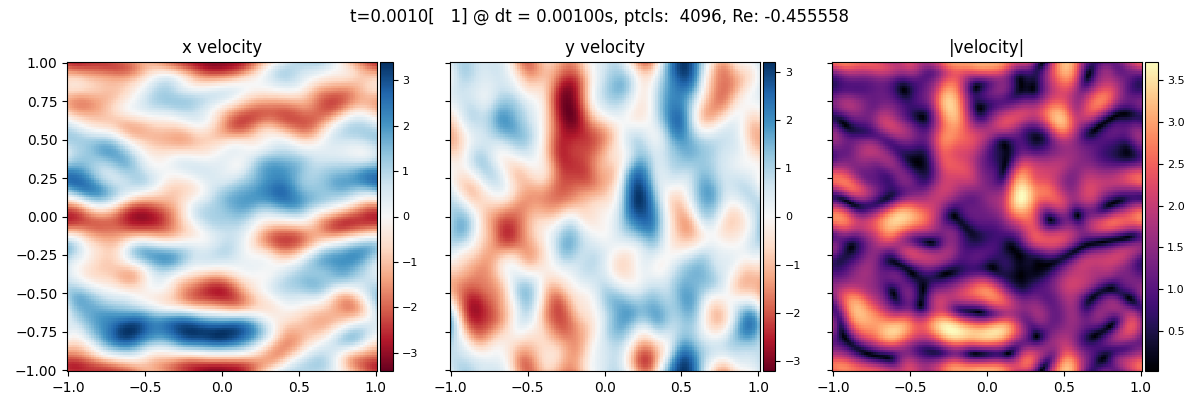

In [10]:

def updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis):
    nx = 128
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,nx)
    xx, yy = np.meshgrid(x,y)
    pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
    i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                                sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                                sphSimulation.config['particle']['support'], 
                                                                sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

    vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')
    xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
    yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

    vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]

    # pMeshV.set_array(vorticity)
    pMeshX.set_array(xVel)
    pMeshY.set_array(yVel)
    pMeshN.set_array(np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2))

        
    positions = state['fluidPosition'].detach().cpu().numpy()
    data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
    minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
    maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
    # y = np.remainder(positions - minD, maxD - minD) + minD
    # sc.set_offsets(np.c_[y[:,0], y[:,1]])
    # sc.set_array(data)

    nu = np.log(data.max()/4) /(-2 * np.pi**2 * sphSimulation.simulationState['time']) / 4
    Re = data.max() * 2 / nu
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d, Re: %g'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles'], Re))
    # axis[0,0].cla()
    # axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
    # axis[0,0].set_xlim(-1,1)
    # axis[0,0].set_ylim(-1,1)
    # axis[0,0].set_aspect(1)
    
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = True, sharey = True, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'RdBu', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]
state = sphSimulation.simulationState
# pMeshV = pMesh2(fig,axis[0,0], xx, yy, vorticity, 'vorticity')
positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
y = np.remainder(positions - minD, maxD - minD) + minD
# sc = axis[0,0].scatter(y[:,0], y[:,1], c = torch.linalg.norm(sphSimulation.simulationState['fluidVelocity'], dim = -1).cpu().numpy(), s = 1,cmap = 'magma')
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
# axis[0,0].set_box_aspect(1)
# axis[0,0].set_title('Particle |velocity|')

pMeshX = pMesh2(fig,axis[0,0], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,1], xx, yy, yVel, 'y velocity')
pMeshN = pMesh( fig,axis[0,2], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
nu = np.log(data.max()) /(-2 * np.pi**2 * sphSimulation.simulationState['time']) / 4
Re = data.max() * 2 / nu
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d, Re: %g'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles'], Re))
        
fig.tight_layout()

# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = '../../images/periodic/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
# if not os.path.exists(path):
#     os.makedirs(path)
# timesteps = 4096 * 4
# # timesteps = 2424
# for i in tqdm(range(timesteps)):
#     sphSimulation.integrate()
# #     break
# #     sphSimulation.timestep()
#     if i  % 64 == 0 or i == timesteps - 1:
# #     if True:
#         state = sphSimulation.simulationState        

#         updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis)
        
#         fig.canvas.draw()
#         fig.canvas.flush_events()
        
#         imagePath = path + '%05d.png' % state['timestep']
#         # plt.savefig(imagePath)

In [11]:
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = '../../images/periodic/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
# if not os.path.exists(path):
#     os.makedirs(path)
timesteps = 128
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 64 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState        

        updatePlot(sphSimulation, None, pMeshX, pMeshY, pMeshN, None, fig, axis)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
        # imagePath = path + '%05d.png' % state['timestep']
        # plt.savefig(imagePath)

  0%|          | 0/128 [00:00<?, ?it/s]

In [12]:
# seeds = torch.randint(low = 0, high = 2**30, size = (36,1)).flatten().numpy().tolist()
# print(seeds)

In [13]:
# config = '../../datasets/configs/periodicDomain.toml'

# with open(config, 'r') as file:
#     tomlConfig = file.read()
# parsedConfig = tomli.loads(tomlConfig)

# simulationModel = deltaSPHSimulation
# # simulationModel = dfsphSimulation
# for seed in tqdm(seeds):
#     parsedConfig['generative']['seed'] = seed
#     parsedConfig['generative']['prefix'] = 'generativePeriodic_base_1_octaves_3'
#     sphSimulation = simulationModel(parsedConfig)
#     sphSimulation.initializeSimulation()
#     state = sphSimulation.simulationState
#     state['fluidVelocity'] = 4.0 * state['fluidVelocity'] / torch.max(torch.linalg.norm(state['fluidVelocity'], dim = -1))
#     timesteps = 4096 * 4
#     for i in tqdm(range(timesteps),leave = False):
#         sphSimulation.integrate()

In [14]:
# sphSimulation.perennialState

In [15]:
# sphSimulation.simulationState

In [16]:
# positions = torch.clone(sphSimulation.perennialState['fluidPosition'])
# fig, axis = plt.subplots(1, 1, figsize=(7,7), sharex = False, sharey = False, squeeze = False)

# axis[0,0].scatter(positions[:,0].detach().cpu().numpy(), positions[:,1].detach().cpu().numpy(), s = 1)

In [17]:

@torch.jit.script
def mod(x, min : float, max : float):
    return torch.where(torch.abs(x) > (max - min) / 2, torch.sgn(x) * ((torch.abs(x) + min) % (max - min) + min), x)
    
@torch.jit.script
def radiusNaive(x, y, hx, hy, periodicX : bool = False, periodicY : bool = False, minDomain = None, maxDomain = None, mode : str = 'gather'):
    if periodicX and not periodicY:
        pos_x = torch.stack((torch.remainder(x[:,0] - minDomain[0], maxDomain[0] - minDomain[0]) + minDomain[0], x[:,1]), dim = 1)
        pos_y = torch.stack((torch.remainder(y[:,0] - minDomain[0], maxDomain[0] - minDomain[0]) + minDomain[0], y[:,1]), dim = 1)
    elif not periodicX and periodicY:
        pos_x = torch.stack((x[:,0], torch.remainder(x[:,1] - minDomain[1], maxDomain[1] - minDomain[1]) + minDomain[1]), dim = 1)
        pos_y = torch.stack((y[:,0], torch.remainder(y[:,1] - minDomain[1], maxDomain[1] - minDomain[1]) + minDomain[1]), dim = 1)
    elif periodicX and periodicY:
        pos_x = torch.remainder(x - minDomain, maxDomain - minDomain) + minDomain
        pos_y = torch.remainder(y - minDomain, maxDomain - minDomain) + minDomain
    else:
        pos_x = x
        pos_y = y
    
    distanceMatrix_x = pos_x[:,0] - pos_y[:,0,None]
    distanceMatrix_y = pos_x[:,1] - pos_y[:,1,None]
    if periodicX:
        distanceMatrix_x = mod(distanceMatrix_x, minDomain[0], maxDomain[0])
    if periodicY:
        distanceMatrix_y = mod(distanceMatrix_y, minDomain[1], maxDomain[1])
    
    distanceMatrix = torch.sqrt(distanceMatrix_x**2 + distanceMatrix_y**2)
    
    indexI, indexJ = torch.meshgrid(torch.arange(x.shape[0]).to(x.device), torch.arange(y.shape[0]).to(y.device), indexing = 'xy')
    if mode == 'gather':        
        gatherMatrix = hx.repeat(hy.shape[0],1)
        adjacencyDense = distanceMatrix <= gatherMatrix
        supports = gatherMatrix[adjacencyDense]
    elif mode == 'scatter':        
        scatterMatrix = hy.repeat(hx.shape[0],1).mT
        adjacencyDense = distanceMatrix <= scatterMatrix
        supports = scatterMatrix[adjacencyDense]
    else:
        symmetricMatrix = (hx + hy[:,None]) / 2
        adjacencyDense = distanceMatrix <= symmetricMatrix
        supports = symmetricMatrix[adjacencyDense]
    
    ii = indexI[adjacencyDense]
    jj = indexJ[adjacencyDense]

    return ii, jj, distanceMatrix[adjacencyDense], torch.stack((distanceMatrix_x[adjacencyDense], distanceMatrix_y[adjacencyDense]), dim = 1), supports

In [18]:

# periodicX = True
# periodicY = True
# minDomain = [-1,-1]
# maxDomain = [1,1]


# prop_cycle = plt.rcParams['axes.prop_cycle']
# colors = prop_cycle.by_key()['color']


# fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

# xx = torch.linspace(-1, 1, 1024)
# nx = xx / (xx + 1e-12)
# dx = 1e-3

# axis[0,0].axvline(0, ls = ':', c = 'black', alpha = 0.5)
# axis[0,0].axvline(1, ls = ':', c = 'black', alpha = 0.5)
# axis[0,0].axhline(0, ls = ':', c = 'black', alpha = 0.5)
# axis[0,1].axvline(0, ls = ':', c = 'black', alpha = 0.5)
# axis[0,1].axvline(1, ls = ':', c = 'black', alpha = 0.5)
# axis[0,1].axhline(0, ls = ':', c = 'black', alpha = 0.5)

# xrel = 1


# axis[0,1].plot(xx, mod(xrel - xx, minDomain[0], maxDomain[0]))
# axis[0,0].plot(xx, xrel -xx, label = xrel)

# xrel = 0
# axis[0,1].plot(xx, mod(xrel - xx, minDomain[0], maxDomain[0]))
# axis[0,0].plot(xx, xrel -xx, label = xrel)
              
# xrel = -1
# axis[0,1].plot(xx, mod(xrel - xx, minDomain[0], maxDomain[0]))
# axis[0,0].plot(xx, xrel -xx, label = xrel)

# axis[0,0].legend()
# fig.tight_layout()

In [19]:
# mod(1 - xx, minDomain[0], maxDomain[0])

In [20]:
# xx

In [21]:
# positions = sphSimulation.simulationState['fluidPosition']
# x = torch.clone(positions)
# y = torch.clone(positions)

# periodicX = True
# periodicY = True
# minDomain = [-1,-1]
# maxDomain = [1,1]


# minD = torch.tensor(minDomain).to(x.device).type(x.dtype)
# maxD = torch.tensor(maxDomain).to(x.device).type(x.dtype)

# if periodicX and not periodicY:
#     pos_x = torch.stack((torch.remainder(x[:,0] - minD[0], maxD[0] - minD[0]) + minD[0], x[:,1]), dim = 1)
#     pos_y = torch.stack((torch.remainder(y[:,0] - minD[0], maxD[0] - minD[0]) + minD[0], y[:,1]), dim = 1)
# elif not periodicX and periodicY:
#     pos_x = torch.stack((x[:,0], torch.remainder(x[:,1] - minD[1], maxD[1] - minD[1]) + minD[1]), dim = 1)
#     pos_y = torch.stack((y[:,0], torch.remainder(y[:,1] - minD[1], maxD[1] - minD[1]) + minD[1]), dim = 1)
# elif periodicX and periodicY:
#     pos_x = torch.remainder(x - minD, maxD - minD) + minD
#     pos_y = torch.remainder(y - minD, maxD - minD) + minD
# else:
#     pos_x = x
#     pos_y = y

# # x = torch.remainder(ptcls - minD, maxD - minD) + minD

In [22]:
# distanceMatrix_x = pos_x[:,0] - pos_y[:,0,None]
# distanceMatrix_y = pos_x[:,1] - pos_y[:,1,None]

# distanceMatrix_x = (distanceMatrix_x) % ((maxDomain[0] - minDomain[0]) / 2)
# distanceMatrix_y = (distanceMatrix_y) % ((maxDomain[1] - minDomain[1]) / 2)

# distanceMatrix = torch.sqrt(distanceMatrix_x**2 + distanceMatrix_y**2)

# torch.max(distanceMatrix_x)

In [23]:
# distanceMatrix.shape

In [24]:
# print(pos_x.shape, pos_y.shape)
# print(x.shape, y.shape)

In [25]:
# distances_x = pos_y[j,0] - pos_x[i,0]
# distances_y = pos_y[j,1] - pos_x[i,1]
# if periodicX:
#     distances_x = (distances_x) % ((maxDomain[0] - minDomain[0]) / 2)
# if periodicY:
#     distances_y = (distances_y) % ((maxDomain[1] - minDomain[1]) / 2)
# distances = torch.stack((distances_x, distances_y), dim = 1)
# print(distances.shape)

In [26]:
# xij_normed = torch.nn.functional.normalize(xij)
# rij_normed = rij / hij

In [27]:
@torch.jit.script
def cpow(q, p : int):
    return torch.clamp(q, 0, 1)**p
# @torch.jit.script
# def wendland4(q, h):
#     C = 7 / np.pi
#     b1 = torch.pow(1. - q, 4)
#     b2 = 1.0 + 4.0 * q
#     return b1 * b2 * C / h**2  
    
class Wendland2:
    @staticmethod
    @torch.jit.script
    def kernel(rij, hij, dim : int = 2):
        C = [5/4, 7 / np.pi, 21/ (2 * np.pi)]
        
        if dim == 1:
            k = cpow(1 - rij, 3) * (1 + 3 * rij)
        else:
            k = cpow(1 - rij, 4) * (1 + 4 * rij)
        return k * C[dim - 1] / hij**dim
        
    @staticmethod
    @torch.jit.script
    def kernelGradient(rij, xij, hij, dim : int = 2):
        C = [5/4, 7 / np.pi, 21/ (2 * np.pi)]
        
        if dim == 1:
            k = -12 * rij * cpow(1 - rij, 2)
        else:
            k = -20 * rij * cpow(1 - rij, 3)
        return xij * (k * C[dim - 1] / hij**(dim + 1))[:,None]
class Wendland4:
    @staticmethod
    @torch.jit.script
    def kernel(rij, hij, dim : int = 2):
        C = [3/2, 9 / np.pi, 495/ (32 * np.pi)]
        
        if dim == 1:
            k = cpow(1 - rij, 5) * (1 + 5 * rij + 8 * rij**2)
        else:
            k = cpow(1 - rij, 6) * (1 + 6 * rij + 35/3 * rij **2)
        return k * C[dim - 1] / hij**dim
        
    @staticmethod
    @torch.jit.script
    def kernelGradient(rij, xij, hij, dim : int = 2):
        C = [3/2, 9 / np.pi, 495/ (32 * np.pi)]
        
        if dim == 1:
            k = -14 * rij * (4 *rij + 1) * (1 - rij)**4
        else:
            k = -56/3 * rij * (5 * rij + 1) * (1 - rij)**5
        return xij * (k * C[dim - 1] / hij**(dim + 1))[:,None]        
class Wendland6:
    @staticmethod
    @torch.jit.script
    def kernel(rij, hij, dim : int = 2):
        C = [55/32, 78 / (7 * np.pi), 1365/ (64 * np.pi)]
        
        if dim == 1:
            k = cpow(1 - rij, 7) * (1 + 7 * rij + 19 * rij**2 + 21 * rij**3)
        else:
            k = cpow(1 - rij, 8) * (1 + 8 * rij + 25 * rij**2 + 32 * rij**3)
        return k * C[dim - 1] / hij**dim
        
    @staticmethod
    @torch.jit.script
    def kernelGradient(rij, xij, hij, dim : int = 2):
        C = [55/32, 78 / (7 * np.pi), 1365/ (64 * np.pi)]
        
        if dim == 1:
            k = -6 * rij * (35 * rij**2 + 18 * rij + 3) * (1 - rij)**6
        else:
            k = -22 * rij * (16 * rij**2 + 7 *rij + 1) * (1 - rij)**7
        return xij * (k * C[dim - 1] / hij**(dim + 1))[:,None]
class CubicSpline:
    @staticmethod
    @torch.jit.script
    def kernel(rij, hij, dim : int = 2):
        C = [8/3, 80 / (7 * np.pi), 16/ (np.pi)]
        k = cpow(1-rij, 3) - 4 * cpow(1/2 - rij,3)
        return k * C[dim - 1] / hij**dim
        
    @staticmethod
    @torch.jit.script
    def kernelGradient(rij, xij, hij, dim : int = 2):
        C = [8/3, 80 / (7 * np.pi), 16/ (np.pi)]
        k = -3 * cpow(1-rij, 2) + 12 * cpow(1/2 - rij,2)
        return xij * (k * C[dim - 1] / hij**(dim + 1))[:,None]
class QuarticSpline:
    @staticmethod
    @torch.jit.script
    def kernel(rij, hij, dim : int = 2):
        C = [5**5/768, 5**6 * 3 / (2398 * np.pi), 5**6/ (512 * np.pi)]
        k = cpow(1-rij, 4) - 5 * cpow(3/5 - rij, 4) + 10 * cpow(1/5 - rij, 4)
        return k * C[dim - 1] / hij**dim
        
    @staticmethod
    @torch.jit.script
    def kernelGradient(rij, xij, hij, dim : int = 2):
        C = [5**5/768, 5**6 * 3 / (2398 * np.pi), 5**6/ (512 * np.pi)]
        k = -4 * cpow(1-rij, 3) + 20 * cpow(3/5 - rij, 3) - 40 * cpow(1/5 - rij, 3)
        return xij * (k * C[dim - 1] / hij**(dim + 1))[:,None]
class QuinticSpline:
    @staticmethod
    @torch.jit.script
    def kernel(rij, hij, dim : int = 2):
        C = [3**5/40, 3**7 * 7 / (478 * np.pi), 3**7/ (40 * np.pi)]
        k = cpow(1-rij, 5) - 6 * cpow(2/3 - rij, 5) + 15 * cpow(1/3 - rij, 5)
        return k * C[dim - 1] / hij**dim
        
    @staticmethod
    @torch.jit.script
    def kernelGradient(rij, xij, hij, dim : int = 2):
        C = [3**5/40, 3**7 * 7 / (478 * np.pi), 3**7/ (40 * np.pi)]
        k = -5 * cpow(1-rij, 4) + 30 * cpow(2/3 - rij, 4) - 75 * cpow(1/3 - rij, 4)
        return xij * (k * C[dim - 1] / hij**(dim + 1))[:,None]

In [28]:
def getKernel(kernel: str = 'Wendland2'):
    if kernel == 'Wendland2':
        return Wendland2
    elif kernel == 'Wendland4':
        return Wendland4
    elif kernel == 'Wendland6':
        return Wendland6
    elif kernel == 'CubicSpline':
        return CubicSpline
    elif kernel == 'QuarticSpline':
        return QuarticSpline
    elif kernel == 'QuinticSpline':
        return QuinticSpline
    else: return Wendland2

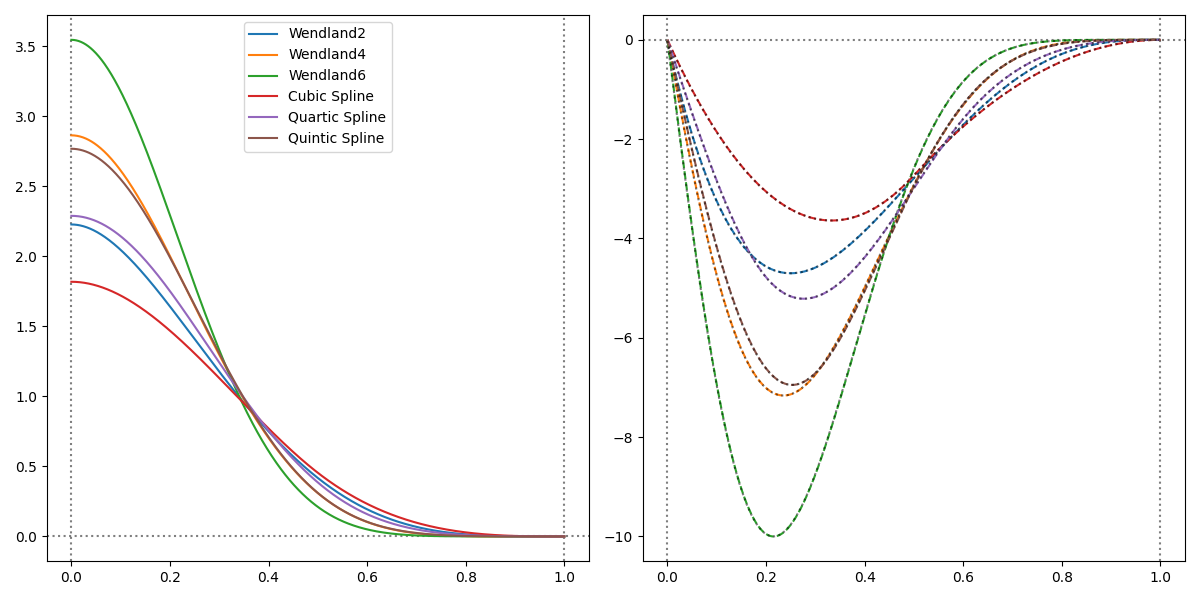

In [29]:

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

xx = torch.linspace(0, 1, 1024)
nx = xx / (xx + 1e-12)
dx = 1e-3

axis[0,0].axvline(0, ls = ':', c = 'black', alpha = 0.5)
axis[0,0].axvline(1, ls = ':', c = 'black', alpha = 0.5)
axis[0,0].axhline(0, ls = ':', c = 'black', alpha = 0.5)
axis[0,1].axvline(0, ls = ':', c = 'black', alpha = 0.5)
axis[0,1].axvline(1, ls = ':', c = 'black', alpha = 0.5)
axis[0,1].axhline(0, ls = ':', c = 'black', alpha = 0.5)

def plotKernel(fig, axis, xx, nx, dx, Kernel, i, label):
    fx = Kernel.kernel(xx, torch.ones_like(xx), 2)
    dfx = Kernel.kernelGradient(xx, nx[:,None], torch.ones_like(xx), 2)
    ndfx = (Kernel.kernel(xx + dx, torch.ones_like(xx), 2) - Kernel.kernel(xx, torch.ones_like(xx), 2)) / dx
    
    axis[0,0].plot(xx,fx, c = colors[i], label = label)
    axis[0,1].plot(xx,dfx[:,0], ls = '--', c = colors[i], label = label)
    axis[0,1].plot(xx,ndfx, ls = ':', c = 'black', alpha = 0.5)


plotKernel(fig, axis, xx, nx, dx, Wendland2, 0, 'Wendland2')
plotKernel(fig, axis, xx, nx, dx, Wendland4, 1, 'Wendland4')
plotKernel(fig, axis, xx, nx, dx, Wendland6, 2, 'Wendland6')
plotKernel(fig, axis, xx, nx, dx, CubicSpline, 3, 'Cubic Spline')
plotKernel(fig, axis, xx, nx, dx, QuarticSpline, 4, 'Quartic Spline')
plotKernel(fig, axis, xx, nx, dx, QuinticSpline, 5, 'Quintic Spline')

axis[0,0].legend()
fig.tight_layout()

In [17]:
# Wendland2.kernel(rij, hij, 2)

In [18]:
def neighborSearch(x, y, hx, hy, periodicX : bool = False, periodicY : bool = False, minDomain = None, maxDomain = None, mode : str = 'gather'):
    if minDomain is not None and isinstance(minDomain, list):
        minD = torch.tensor(minDomain).to(x.device).type(x.dtype)
    else:
        minD = minDomain
    if maxDomain is not None and isinstance(minDomain, list):
        maxD = torch.tensor(maxDomain).to(x.device).type(x.dtype)
    else:
        maxD = maxDomain
    
    
    i, j, rij, xij, hij = radiusNaive(x, y, 
                            hx if isinstance(hx, torch.Tensor) else torch.ones(x.shape[0]).to(x.device).to(x.dtype) * hx, hy if isinstance(hy, torch.Tensor) else torch.ones(y.shape[0]).to(y.device).to(y.dtype) * hy, 
                            periodicX = periodicX, periodicY = periodicY, minDomain = minD, maxDomain = maxD)
    
    xij_normed = torch.nn.functional.normalize(xij)
    rij_normed = rij / hij

    return i, j, rij_normed, xij_normed, hij

In [19]:
@torch.jit.script
def wendland4(q, h):
    C = 7 / np.pi
    b1 = torch.pow(1. - q, 4)
    b2 = 1.0 + 4.0 * q
    return b1 * b2 * C / h**2  
@torch.jit.script
def wendland4Grad(q,r,h):
    C = 7 / np.pi    
    return - r * C * (20. * q * (1. -q)**3/ h**3 )[:,None]

In [22]:
Kernel = getKernel('Wendland2')

positions = sphSimulation.simulationState['fluidPosition']

x = torch.clone(positions)
y = torch.clone(positions[:positions.shape[0]//2,:])
y = torch.clone(positions)
# print(y)
hx = torch.clone(sphSimulation.perennialState['fluidSupport'])
hy = torch.clone(sphSimulation.perennialState['fluidSupport'][:y.shape[0]])


periodicX = True
periodicY = True
minDomain = [-1,-1]
maxDomain = [1,1]

i, j, rij, xij, hij = neighborSearch(x, y, hx, hy, periodicX, periodicY, minDomain, maxDomain)

kernel = Kernel.kernel(rij, hij)
gradKernel = Kernel.kernelGradient(rij, xij, hij)

In [28]:
def sampleRegular(nx = 32, minExtent = [-1, -1], maxExtent = [1,1], targetNeighbors = 50, correctedArea = False):
    dx = (maxExtent[0] - minExtent[0]) / nx            
    area = dx**2
    if correctedArea:
        area =  minimize(lambda r: evalArea(r[0], dx, torch.float32, 'cpu', targetNeighbors = targetNeighbors), area, method="nelder-mead", bounds =[(area * 1e-5,area *2)], tol = 1e-7).x[0]
    support = np.single(np.sqrt(area / np.pi * targetNeighbors))
    
    
    xx = np.linspace(minDomain[0] + dx / 2, maxExtent[0] - dx / 2, nx)
    yy = np.linspace(minDomain[1] + dx / 2, maxExtent[1] - dx / 2, nx)

    XX, YY = np.meshgrid(xx,yy)
    ptcls = np.stack((XX,YY), axis = 2).flatten().reshape((nx * nx, 2))

    return torch.tensor(ptcls), torch.ones(ptcls.shape[0]) * area, torch.ones(ptcls.shape[0]) * support

def sphInterpolation(fluidMasses, fluidDensities, fluidQuantities, fluidNeighbors, fluidKernels, fluidKernelGradients, numParticles):
    i = fluidNeighbors[0]
    j = fluidNeighbors[1]
    return scatter(fluidMasses[1][j] / fluidDensities[1][j] * fluidQuantities[1][j] * fluidKernels, i, dim = 0, dim_size = numParticles, reduce = 'add')


In [24]:
import matplotlib

In [27]:
def visualizeParticles(fig, axis, x, area, h, quantity, periodicX = False, periodicY = False, minDomain = None, maxDomain = None, mapping = '.x', cbar = True, cmap = 'viridis', scaling = 'symlog', s = 4, linthresh = 0.5, midPoint = 1):        
    
    minD = torch.tensor(minDomain).to(x.device).type(x.dtype)
    maxD = torch.tensor(maxDomain).to(x.device).type(x.dtype)
    
    if periodicX and not periodicY:
        pos_x = torch.stack((torch.remainder(x[:,0] - minD[0], maxD[0] - minD[0]) + minD[0], x[:,1]), dim = 1)
    elif not periodicX and periodicY:
        pos_x = torch.stack((x[:,0], torch.remainder(x[:,1] - minD[1], maxD[1] - minD[1]) + minD[1]), dim = 1)
    elif periodicX and periodicY:
        pos_x = torch.remainder(x - minD, maxD - minD) + minD
    else:
        pos_x = x  

    minScale = torch.min(quantity)
    maxScale = torch.max(quantity)
    if 'sym' in scaling:
        minScale = - torch.max(torch.abs(quantity))
        maxScale =   torch.max(torch.abs(quantity))
        if 'log'in scaling:
            norm = matplotlib.colors.SymLogNorm(vmin = minScale, vmax = maxScale, linthresh = linthresh)
        else:
            minScale = - torch.max(torch.abs(quantity - midPoint))
            maxScale =   torch.max(torch.abs(quantity - midPoint))
            norm = matplotlib.colors.CenteredNorm(vcenter = midPoint, halfrange = maxScale)
    else:
        if 'log'in scaling:
            vmm = torch.min(torch.abs(quantity[quantity!= 0]))
            norm = matplotlib.colors.LogNorm(vmin = vmm, vmax = maxScale)
        else:
            norm = matplotlib.colors.Normalize(vmin = minScale, vmax = maxScale)
        
    sc = axis.scatter(pos_x[:,0].detach().cpu().numpy(), pos_x[:,1].detach().cpu().numpy(), s = s, c = quantity.detach().cpu().numpy(), cmap = cmap, norm = norm)
    if cbar:
        ax1_divider = make_axes_locatable(axis)
        cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
        cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
        cb.ax.tick_params(labelsize=8)
    if periodicX:
        axis.axis('equal')
        axis.set_xlim(minDomain[0], maxDomain[0])
        axis.set_ylim(minDomain[1], maxDomain[1])
    else:
        axis.set_aspect('equal', 'box')

    return {'plot': sc, 'cbar': cb if cbar else None, 'periodic': (periodicX, periodicY), 'domain': (minDomain, maxDomain), 'mapping': mapping, 'colormap': cmap, 'scale': scaling, 'size':4}
    

/home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


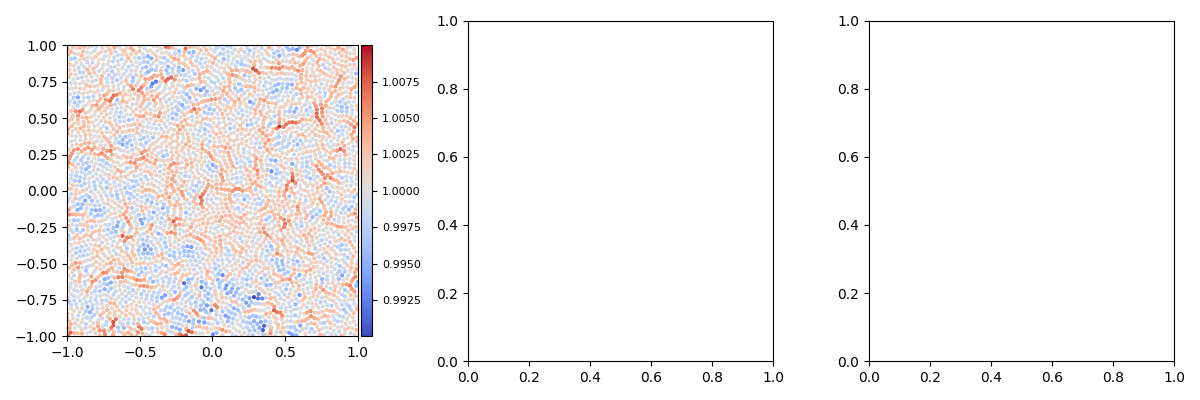

In [29]:


x = torch.clone(positions)
hx = torch.clone(sphSimulation.perennialState['fluidSupport'])
h = torch.max(hx).item()
area = sphSimulation.simulationState['fluidArea']


i, j, rij, xij, hij = neighborSearch(x, x, h, h, True, True, minDomain, maxDomain)
Kernel = getKernel('Wendland2')

kernel = Kernel.kernel(rij, hij)
gradKernel = Kernel.kernelGradient(rij, xij, hij)


density = sphInterpolation((None,sphSimulation.simulationState['fluidArea']), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (i, j), kernel, gradKernel, x.shape[0])
# density = sphInterpolation((None,area), (None, torch.ones_like(area)), (None, torch.ones_like(area)), (i, j), kernel, gradKernel, x.shape[0])



fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)


visualizeParticles(fig, axis[0,0], 
                   x, area, h, density, 
                   periodicX, periodicY, minDomain, maxDomain, 
                   mapping = '.x', cbar = True, cmap = 'coolwarm', scaling = 'sym', s = 4, midPoint = 1)

fig.tight_layout()

In [ ]:
x, area, h = sampleRegular(64, targetNeighbors = 50, correctedArea = True)



# x = torch.clone(positions)
# hx = torch.clone(sphSimulation.perennialState['fluidSupport'])
# h = torch.max(hx).item()

i, j, rij, xij, hij = neighborSearch(x, x, h, h, True, True, minDomain, maxDomain)
Kernel = getKernel('Wendland2')

kernel = Kernel.kernel(rij, hij)
gradKernel = Kernel.kernelGradient(rij, xij, hij)


# density = sphInterpolation((None,sphSimulation.simulationState['fluidArea']), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (i, j), kernel, gradKernel, x.shape[0])
density = sphInterpolation((None,area), (None, torch.ones_like(area)), (None, torch.ones_like(area)), (i, j), kernel, gradKernel, x.shape[0])


fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

sc = axis[0,0].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 4, c = torch.arange(x.shape[0]), cmap = 'twilight')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)
axis[0,0].axis('equal')

ii, ni = torch.unique(i, return_counts = True)
padded_ni = torch.zeros(x.shape[0]).to(x.device).type(ii.dtype)
padded_ni[ii] = ni

sc = axis[0,1].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 4, c = padded_ni.cpu().numpy(), cmap = 'plasma')
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)
axis[0,1].axis('equal')


sc = axis[0,2].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 4, c = density.cpu().numpy())
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)
axis[0,2].axis('equal')

fig.tight_layout()

print('Area: min %g, max %g, mean %g, stddev %g' %(area.min().item(), area.max().item(), area.mean().item(), area.std().item()))
print('rij: min %g, max %g, mean %g, stddev %g' %(rij.min().item(), rij.max().item(), rij.mean().item(), rij.std().item()))
print('kernel: min %g, max %g, mean %g, stddev %g' %(kernel.min().item(), kernel.max().item(), kernel.mean().item(), kernel.std().item()))
print('Density: min %g, max %g, mean %g, stddev %g' %(density.min().item(), density.max().item(), density.mean().item(), density.std().item()))
print(x.shape)

In [ ]:


density = sphInterpolation((None,sphSimulation.simulationState['fluidArea']), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (None, torch.ones_like(sphSimulation.simulationState['fluidArea'])), (i, j), kernel, gradKernel, x.shape[0])

fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

sc = axis[0,0].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 1, c = density.cpu().numpy())
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)

In [ ]:
density

/home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


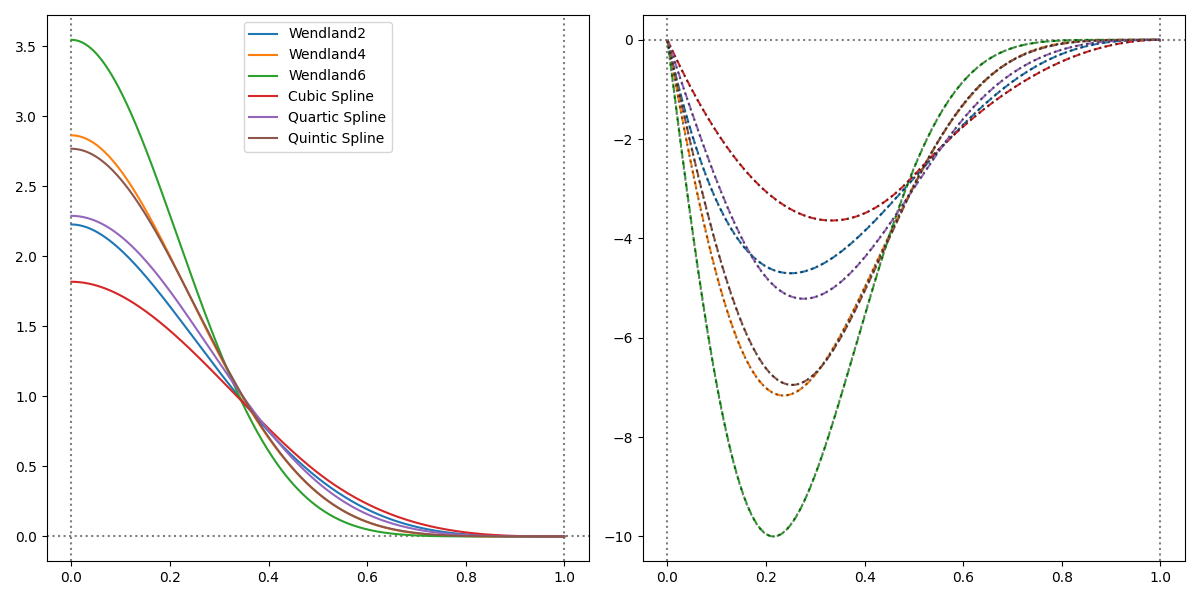

In [ ]:
print(radialDistances.max())
print(hx.max())

In [ ]:
x = torch.clone(positions)
y = torch.clone(positions[:positions.shape[0]//2,:])
# y = torch.clone(positions)
# print(y)
hx = torch.clone(sphSimulation.perennialState['fluidSupport'])
hy = torch.clone(sphSimulation.perennialState['fluidSupport'][:y.shape[0]])


periodicX = True
periodicY = True
minDomain = [-1,-1]
maxDomain = [1,1]

minD = torch.tensor(minDomain).to(x.device).type(x.dtype)
maxD = torch.tensor(maxDomain).to(x.device).type(x.dtype)

i, j, rij, xij, hij = radiusNaive(x, y, hx, hy, periodicX = periodicX, periodicY = periodicY, minDomain = minD, maxDomain = maxD)

neighbors = torch.vstack((i,j))

ii, ni = torch.unique(i, return_counts = True)
padded_ni = torch.zeros_like(hx).type(ii.dtype)
padded_ni[ii] = ni

jj, nj = torch.unique(j, return_counts = True)
padded_nj = torch.zeros_like(hy).type(jj.dtype)
padded_nj[jj] = nj

# display(distanceMatrix < h)
fig, axis = plt.subplots(1, 2, figsize=(12,6), sharex = False, sharey = False, squeeze = False)

sc = axis[0,0].scatter(x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy(), s = 1, c = padded_ni.cpu().numpy())
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)

sc = axis[0,1].scatter(y[:,0].detach().cpu().numpy(), y[:,1].detach().cpu().numpy(), s = 1, c = padded_nj.cpu().numpy())
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8)

fig.tight_layout()

In [ ]:
ii.max()
jj.max()

In [ ]:
((hx + hy[:,None]) / 2).shape

In [ ]:
hy.repeat(hx.shape[0],1).mT.shape

In [ ]:
config = 'configs/periodicDomain.toml'

with open(config, 'r') as file:
    tomlConfig = file.read()
parsedConfig = tomli.loads(tomlConfig)

simulationModel = deltaSPHSimulation
# simulationModel = dfsphSimulation

sphSimulation = simulationModel(parsedConfig)
sphSimulation.initializeSimulation()
state = sphSimulation.simulationState
state['fluidVelocity'] = 4.0 * state['fluidVelocity'] / torch.max(torch.linalg.norm(state['fluidVelocity'], dim = -1))

# A = 1
# B = -1
# k = np.pi
# state['fluidVelocity'][:,0] =  4 * torch.cos(k * state['fluidPosition'][:,0]) * torch.sin(k * state['fluidPosition'][:,1])
# state['fluidVelocity'][:,1] = -4 * torch.sin(k * state['fluidPosition'][:,0]) * torch.cos(k * state['fluidPosition'][:,1])


sphSimulation.integrate()

from BasisConvolution.twoDimensionalSPH.modules.neighborSearch import periodicNeighborSearchXY
from BasisConvolution.twoDimensionalSPH.kernels import kernel

nx = 128
x = np.linspace(-1,1,nx)
y = np.linspace(-1,1,nx)
# x = np.linspace(0,2*np.pi,nx)
# y = np.linspace(0,2*np.pi,nx)
xx, yy = np.meshgrid(x,y)
pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
print(pos.shape)
i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                            sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                            sphSimulation.config['particle']['support'], 
                                                            sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])


vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')

fig, axis = plt.subplots(1, 6, figsize=(20,4), sharex = False, sharey = False, squeeze = False)
xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)
# axis[0,0].set_xlim(0,2*np.pi)
# axis[0,0].set_ylim(0,2*np.pi)
axis[0,0].set_aspect(1)
axis[0,0].axis('equal')
# fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'RdBu', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc
def pMesh3(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'jet', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]
divergence = np.gradient(xVel)[0] - np.gradient(xVel)[1]

pMeshV = pMesh3(fig,axis[0,1], xx, yy, divergence, 'divergence')
pMeshV = pMesh2(fig,axis[0,2], xx, yy, vorticity, 'vorticity')
pMeshX = pMesh2(fig,axis[0,3], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,4], xx, yy, yVel, 'y velocity')
pMeshN = pMesh( fig,axis[0,5], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles']))

fig.tight_layout()

In [ ]:
fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = False, sharey = False, squeeze = False)
state = sphSimulation.simulationState
axis[0,0].set_xticks([])
axis[0,0].set_yticks([])

positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
data = state['fluidPressure'].detach().cpu().numpy()
# data = ni.detach().cpu().numpy()

minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
y = np.remainder(positions - minD, maxD - minD) + minD

sc = axis[0,0].scatter(y[:,0], y[:,1], c = data, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.suptitle('Generated [%2d:%2d]+[%2d:%2d] res, %2dx%2d noise, %3.2g @ seed %5d' % (sphSimulation.config['generative']['nb'][0],sphSimulation.config['generative']['nb'][1],sphSimulation.config['generative']['nd'][0],sphSimulation.config['generative']['nd'][1], sphSimulation.config['generative']['res'], sphSimulation.config['generative']['octaves'], sphSimulation.config['generative']['persistance'], sphSimulation.config['generative']['seed']))
axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d'%(state['time'], state['timestep'], state['dt'],state['numParticles']))

axis[0,0].set_xlim(-1.1,1.1)
axis[0,0].set_ylim(-1.1,1.1)
axis[0,0].axvline(-1)
axis[0,0].axvline(1)
axis[0,0].axhline(-1)
axis[0,0].axhline(1)


fig.tight_layout()



In [ ]:

nx = 128
x = np.linspace(-1,1,nx)
y = np.linspace(-1,1,nx)
xx, yy = np.meshgrid(x,y)
pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                            sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                            sphSimulation.config['particle']['support'], 
                                                            sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')

fig, axis = plt.subplots(1, 1, figsize=(6,6), sharex = False, sharey = False, squeeze = False)
xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)
axis[0,0].set_aspect(1)
axis[0,0].axis('equal')

In [ ]:
import seaborn as sns

In [ ]:

def updatePlot(sphSimulation, pMeshX, pMeshY, pMeshN, fig, axis):
    nx = 128
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,nx)
    xx, yy = np.meshgrid(x,y)
    pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
    i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                                sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                                sphSimulation.config['particle']['support'], 
                                                                sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

    vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')
    xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
    yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

    pMeshX.set_array(xVel)
    pMeshY.set_array(yVel)
    pMeshN.set_array(np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2))

    # axis[0,0].cla()
    # axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
    # axis[0,0].set_xlim(-1,1)
    # axis[0,0].set_ylim(-1,1)
    axis[0,0].set_aspect(1)
    
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'vlag', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
    
pMeshX = pMesh2(fig,axis[0,0], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,1], xx, yy, yVel, 'y velocity')
pMeshN = pMesh(fig,axis[0,2], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles']))
        
fig.tight_layout()

In [ ]:

def updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis):
    nx = 128
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,nx)
    xx, yy = np.meshgrid(x,y)
    pos = torch.tensor(np.stack((xx,yy), axis = 2).reshape(nx * nx, 2), device = sphSimulation.simulationState['fluidPosition'].device, dtype = sphSimulation.simulationState['fluidPosition'].dtype)
#     print(pos.shape)
    i, j, distances, radialDistances = periodicNeighborSearchXY(pos, sphSimulation.simulationState['fluidPosition'], 
                                                                sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 
                                                                sphSimulation.config['particle']['support'], 
                                                                sphSimulation.config['periodicBC']['periodicX'], sphSimulation.config['periodicBC']['periodicY'])

    vel = scatter(sphSimulation.simulationState['fluidVelocity'][i] * (sphSimulation.simulationState['fluidArea'][i] / sphSimulation.simulationState['fluidDensity'][i] * kernel(radialDistances, sphSimulation.config['particle']['support']))[:,None], j, dim = 0, dim_size = nx**2, reduce = 'sum')
    xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
    yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()

    vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]

    # pMeshV.set_array(vorticity)
    pMeshX.set_array(xVel)
    pMeshY.set_array(yVel)
    pMeshN.set_array(np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2))

        
    positions = state['fluidPosition'].detach().cpu().numpy()
    data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
    minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
    maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
    # y = np.remainder(positions - minD, maxD - minD) + minD
    # sc.set_offsets(np.c_[y[:,0], y[:,1]])
    # sc.set_array(data)

    nu = np.log(data.max()/4) /(-2 * np.pi**2 * sphSimulation.simulationState['time']) / 4
    Re = data.max() * 2 / nu
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d, Re: %g'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles'], Re))
    # axis[0,0].cla()
    # axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
    # axis[0,0].set_xlim(-1,1)
    # axis[0,0].set_ylim(-1,1)
    # axis[0,0].set_aspect(1)
    
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = True, sharey = True, squeeze = False)


def pMesh(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'magma')
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

def pMesh2(fig, axis, xx,yy,data,title):
    sc = axis.pcolormesh(xx,yy,data, cmap = 'RdBu', vmin = -np.max(np.abs(data)), vmax = np.max(np.abs(data)))
    # sc = axis.pcolormesh(xx,yy,data, cmap = 'icefire', vmin = -2.5, vmax = 2.5)
    axis.axis('equal')

    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    return sc

xVel = vel.reshape(nx,nx,2)[:,:,0].detach().cpu().numpy()
yVel = vel.reshape(nx,nx,2)[:,:,1].detach().cpu().numpy()
vorticity = np.gradient(yVel)[0] - np.gradient(xVel)[1]
state = sphSimulation.simulationState
# pMeshV = pMesh2(fig,axis[0,0], xx, yy, vorticity, 'vorticity')
positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
minD = torch.tensor(sphSimulation.config['domain']['min']).cpu().numpy()
maxD = torch.tensor(sphSimulation.config['domain']['max']).cpu().numpy()
y = np.remainder(positions - minD, maxD - minD) + minD
# sc = axis[0,0].scatter(y[:,0], y[:,1], c = torch.linalg.norm(sphSimulation.simulationState['fluidVelocity'], dim = -1).cpu().numpy(), s = 1,cmap = 'magma')
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
# axis[0,0].set_box_aspect(1)
# axis[0,0].set_title('Particle |velocity|')

pMeshX = pMesh2(fig,axis[0,0], xx, yy, xVel, 'x velocity')
pMeshY = pMesh2(fig,axis[0,1], xx, yy, yVel, 'y velocity')
pMeshN = pMesh( fig,axis[0,2], xx, yy, np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), '|velocity|')
    
# axis[0,0].streamplot(xx,yy,xVel, yVel,color = np.linalg.norm(vel.reshape(nx,nx,2).detach().cpu().numpy(), axis = 2), density = 2)
# axis[0,0].set_xlim(-1,1)
# axis[0,0].set_ylim(-1,1)
# axis[0,0].set_aspect(1)
# axis[0,0].axis('equal')
nu = np.log(data.max()) /(-2 * np.pi**2 * sphSimulation.simulationState['time']) / 4
Re = data.max() * 2 / nu
fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d, Re: %g'%(sphSimulation.simulationState['time'], sphSimulation.simulationState['timestep'], sphSimulation.simulationState['dt'],sphSimulation.simulationState['numParticles'], Re))
        
fig.tight_layout()

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
path = '../../images/periodic/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
if not os.path.exists(path):
    os.makedirs(path)
timesteps = 4096 * 4
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 64 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState        

        updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
        imagePath = path + '%05d.png' % state['timestep']
        # plt.savefig(imagePath)

In [ ]:
nu = np.log(data.max()) /(-2 * np.pi**2 * sphSimulation.simulationState['time'])

In [ ]:
data.max() * 2 / nu

In [ ]:
np.log(data.max()/4) /(-2) / sphSimulation.simulationState['time']

In [ ]:
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
path = '../../images/periodic/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
if not os.path.exists(path):
    os.makedirs(path)
timesteps = 4096 * 4
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 64 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState        

        updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
        imagePath = path + '%05d.png' % state['timestep']
        # plt.savefig(imagePath)

In [ ]:
timesteps = 4096 * 4
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 64 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState        

        updatePlot(sphSimulation, sc, pMeshX, pMeshY, pMeshN, pMeshV, fig, axis)
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
        imagePath = path + '%05d.png' % state['timestep']
        # plt.savefig(imagePath)

In [ ]:
sphSimulation.simulationState['fluidNeighbors'], sphSimulation.simulationState['fluidDistances'], sphSimulation.simulationState['fluidRadialDistances'] = sphSimulation.neighborSearch.search(sphSimulation.simulationState, sphSimulation)
sphSimulation.boundaryModule.boundaryFilterNeighborhoods(sphSimulation.simulationState, sphSimulation)
sphSimulation.boundaryModule.boundaryNeighborhoodSearch(sphSimulation.simulationState, sphSimulation)

sphSimulation.sphDensity.evaluate(sphSimulation.simulationState, sphSimulation)    
sphSimulation.boundaryModule.evalBoundaryDensity(sphSimulation.simulationState, sphSimulation) 
sphSimulation.simulationState['fluidAcceleration'] = torch.zeros_like(sphSimulation.simulationState['fluidVelocity'])   
sphSimulation.gravityModule.evaluate(sphSimulation.simulationState, sphSimulation)
sphSimulation.simulationState['densityIterations'] = sphSimulation.DFSPH.incompressibleSolver(sphSimulation.simulationState, sphSimulation)
sphSimulation.simulationState['fluidAcceleration'] += sphSimulation.simulationState['fluidPredAccel']
sphSimulation.velocityDiffusionModule.evaluate(sphSimulation.simulationState, sphSimulation)    

fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)
state = sphSimulation.simulationState
axis[0,0].set_xticks([])
axis[0,0].set_yticks([])

positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 4)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.suptitle('Generated [%2d:%2d]+[%2d:%2d] res, %2dx%2d noise, %3.2g @ seed %5d' % (sphSimulation.config['generative']['nb'][0],sphSimulation.config['generative']['nb'][1],sphSimulation.config['generative']['nd'][0],sphSimulation.config['generative']['nd'][1], sphSimulation.config['generative']['res'], sphSimulation.config['generative']['octaves'], sphSimulation.config['generative']['persistance'], sphSimulation.config['generative']['seed']))
axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)

fig.tight_layout()


In [ ]:
# print(sphSimulation.config['fluid'])

In [ ]:
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = './outputCollision/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
# if not os.path.exists(path):
#     os.makedirs(path)

In [ ]:
timesteps = 128
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 1 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState
        positions = state['fluidPosition'].detach().cpu().numpy()

#         positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
        
        data = state['fluidDensity'].detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy() * 0
        
#         data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
        data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
#         data = torch.linalg.norm(state['fluidUpdate'], dim=1).detach().cpu().numpy()
        
#         data = state['fluidPressure'].detach().cpu().numpy()
#         data = sphSimulation.deltaSPH.pressure.detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

#         positions = np.vstack((positions, positions2))
#         data = np.hstack((data, data2))

        cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
        sc.set_offsets(positions)
        sc.set_array(data)


        axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
        if 'densityErrors' in state and not 'divergenceErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
        if 'divergenceErrors' in state and not 'densityErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
        if 'densityErrors' in state and 'divergenceErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
#         imagePath = path + '%05d.png' % state['timestep']
#         plt.savefig(imagePath)

In [ ]:
from BasisConvolution.modules.densityDiffusion import computeNormalizationMatrix
from BasisConvolution.kernels import kernel, spikyGrad, kernelGradient
simulationState = sphSimulation.simulationState
normalizationMatrix = computeNormalizationMatrix(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
                                                                                                  simulationState['fluidPosition'], simulationState['fluidPosition'], simulationState['fluidVolume'], simulationState['fluidVolume'],\
                                                                                                  simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
                                                                                                  sphSimulation.densityDiffusionModule.support, simulationState['fluidDensity'].shape[0], sphSimulation.densityDiffusionModule.eps)     
normalizationMatrix += sphSimulation.boundaryModule.computeNormalizationMatrices(simulationState, sphSimulation)
ni = simulationState['fluidNeighbors'][0]

In [ ]:
def gj_solve(m=[1., 0.], n=3, nb=1, result=[0.0, 0.0]):
    r"""A gauss-jordan method to solve an augmented matrix.
    The routine is given the augmented matrix, the number of rows/cols in the
    original matrix and the number of added columns. The result is stored in
    the result array passed.
    Parameters
    ----------
    m : list: a flattened list representing the augmented matrix [A|b].
    n : int: number of columns/rows used from A in augmented_matrix.
    nb: int: number of columns added to A.
    result: list: with size n*nb
    References
    ----------
    https://ricardianambivalence.com/2012/10/20/pure-python-gauss-jordan
    -solve-ax-b-invert-a/
    """

    i, j, eqns, colrange, augCol, col, row, bigrow, nt = 0,0,0,0,0,0,0,0,0
    eqns = n
    colrange = n
    augCol = n + nb
    nt = n + nb

    for col in range(colrange):
        bigrow = col
        for row in range(col + 1, colrange):
            if abs(m[nt*row + col]) > abs(m[nt*bigrow + col]):
                bigrow = row
                temp = m[nt*row + col]
                m[nt*row + col] = m[nt*bigrow + col]
                m[nt*bigrow + col] = temp
    print(m.reshape(4,3))
    rr, rrcol, rb, rbr, kup, kupr, kleft, kleftr = 0,0,0,0,0,0,0,0
    for rrcol in range(0, colrange):
        for rr in range(rrcol + 1, eqns):
            dnr = float(m[nt*rrcol + rrcol])
            if abs(dnr) < 1e-12:
                return 1.0
            cc = -float(m[nt*rr + rrcol]) / dnr
            for j in range(augCol):
                m[nt*rr + j] = m[nt*rr + j] + cc * m[nt*rrcol + j]
    print(m.reshape(4,3))

    backCol, backColr = 0,0
    tol = 1.0e-12
    for rbr in range(eqns):
        rb = eqns - rbr - 1
        if (m[nt*rb + rb] == 0):
            if abs(m[nt*rb + augCol - 1]) > tol:
                # Error, singular matrix.
                return 1.0
        else:
            for backColr in range(rb, augCol):
                backCol = rb + augCol - backColr - 1
                m[nt*rb + backCol] = m[nt*rb + backCol] / m[nt*rb + rb]
            if not (rb == 0):
                for kupr in range(rb):
                    kup = rb - kupr - 1
                    for kleftr in range(rb, augCol):
                        kleft = rb + augCol - kleftr - 1
                        kk = -m[nt*kup + rb] / m[nt*rb + rb]
                        m[nt*kup + kleft] = (m[nt*kup + kleft] +
                                             kk * m[nt*rb + kleft])
    print(m.reshape(4,3))

    for i in range(n):
        for j in range(nb):
            result[nb*i + j] = m[nt*i + n + j]

    return 0.0

In [ ]:
normalizationMatrix.shape
expanded = torch.zeros((normalizationMatrix.shape[0],3,3))
expanded[:,:2,:2] = normalizationMatrix
n = 2
nt = n + 1
expanded = expanded.reshape(normalizationMatrix.shape[0],9)[ni,:]
print(expanded.shape)
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)


temp = torch.zeros((ni.shape[0], 12))
res  = torch.zeros((ni.shape[0], 3))
for i in range(n):
    for j in range(n):
        temp[:,nt * i + j] = expanded[:,3 * i + j]
#         print(expanded[:,3 * i + j].shape)
    temp[:, nt*i + n] = gradW[:,i]
print(temp.reshape(ni.shape[0],4,3))
print(normalizationMatrix[ni])

In [ ]:
batch_gj_solve(temp, n, 1, res)

In [ ]:
normalizationMatrix.shape
expanded = torch.zeros((normalizationMatrix.shape[0],3,3))
expanded[:,:2,:2] = normalizationMatrix
n = 2
nt = n + 1
expanded = expanded.reshape(normalizationMatrix.shape[0],9)[ni,:]
print(expanded.shape)
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)


temp = torch.zeros((ni.shape[0], 12))
res  = torch.zeros((ni.shape[0], 3))
for i in range(n):
    for j in range(n):
        temp[:,nt * i + j] = expanded[:,3 * i + j]
#         print(expanded[:,3 * i + j].shape)
    temp[:, nt*i + n] = gradW[:,i]
# print(temp.reshape(ni.shape[0],4,3))
# print(normalizationMatrix[ni])

gj_solve(temp[1], n, 1, res[1])
print(temp[1].reshape(4,3))
print(res[1])

In [ ]:
normalizationMatrix.device

In [ ]:
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)    
normalizedGradients = invertNormalizationMatrix_GJ(normalizationMatrix, gradW, ni)

In [ ]:
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)    
normalizedGradients = invertNormalizationMatrix_PINV(normalizationMatrix, gradW, ni)

In [ ]:
dwij_mag = torch.linalg.norm(gradW, axis = 1, ord = 1)
norm_mag = torch.linalg.norm(normalizedGradients, axis = 1, ord = 1)

eps = 1e-4 * sphSimulation.densityDiffusionModule.support
tol = 0.1
change = abs(norm_mag - dwij_mag) / (dwij_mag + eps)
normalizedGradients = torch.where((change < tol)[:,None], normalizedGradients, gradW)

# print(change)

In [ ]:
print(m[1].reshape(4,3))
print(res[1])

In [ ]:
print(temp[1].reshape(4,3))
print(res[1])

In [ ]:
pinv = torch.linalg.pinv(normalizationMatrix[0])
print(normalizationMatrix[0])
print(pinv)
print(pinv * normalizationMatrix[0])
print(gradW[1])
print(torch.mv(pinv, gradW[1]))


In [ ]:
# debugPrint(sphSimulation.config['particle']['support'])
# debugPrint(sphSimulation.simulationState['fluidSupport'])

In [ ]:
sphSimulation.outFile.close()
# debugPrint(sphSimulation.outFile.keys())

In [ ]:
# fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = False)
# state = sphSimulation.simulationState

# positions = state['fluidPosition'].detach().cpu().numpy()
# data = state['fluidDensity'].detach().cpu().numpy()

# positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
# data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

# # data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
# # data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()

# # positions = np.vstack((positions, positions2))
# # data = np.hstack((data, data2))

# # data = sphSimulation.DFSPH.fluidAlpha
# data = state['fluidPressure']

# # positions = positions2
# # data = data2

# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
# axis[0,0].axis('equal')

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# # quiverData = state['fluidUpdate'].detach().cpu().numpy()
# # qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
# #                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
# if 'densityErrors' in state and not 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
# if 'divergenceErrors' in state and not 'densityErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
# if 'densityErrors' in state and 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

# fig.tight_layout()



In [ ]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            sphSimulation.integrate()
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")